In [4]:
import numpy as np
import h5py
#compute filter importance scores
f = h5py.File("scores.h5","r")
hyp_scores = np.array(f['hyp_imp'][:])
sequence_onehot = np.array(f['seq'][:])
imp_scores = sequence_onehot*hyp_scores
del hyp_scores

In [10]:
TAL1_hocomoco_pwm = np.array([
[float(x) for x in row.split("\t")] for row in
#"""-0.1534218054606978	0.4248884005542006	0.03874842366748681	-0.5563400288274302
#0.6464252650829619	-0.19096598877289345	-0.4517428977281205	-0.46423468265484735
#0.09778278471982192	-1.7701210752371432	0.6587683755978941	-0.22997490888551778
#-0.3570577390357126	0.015679997751073114	0.6949091007770549	-1.2696234647115647
#0.7960986345594286	-0.1534218054606978	-0.9376103830414496	-0.6277442179623938
#0.8847264425178556	-2.2340103118057417	-0.14425194284148976	-0.5026745162600582
"""0.46041545716766114	-0.7879487534832245	0.6505565864406581	-3.1262106111200567
-1.9199997006100191	1.3217083373824634	-2.694308015795771	-3.324736791140142
1.3068477609048863	-3.903141843818025	-3.324736791140142	-1.3889770090864402
-2.8186351867496584	-1.2418852451298863	1.229040024674195	-1.454459020739145
0.4453438583421999	0.3272783608001891	-0.14425194284148976	-1.6813854611337156
-1.2418852451298863	-2.9606438896517475	-2.2340103118057417	1.2675888612037503
-1.8176277056823105	-2.694308015795771	1.2496331898723319	-1.2696234647115647
-1.000060890477635	-0.6887818819947552	0.3215658109169486	0.5599984365563851
-0.7537887239776389	-0.03211743511552166	0.274651146968163	0.21909970310567795""".split("\n")])

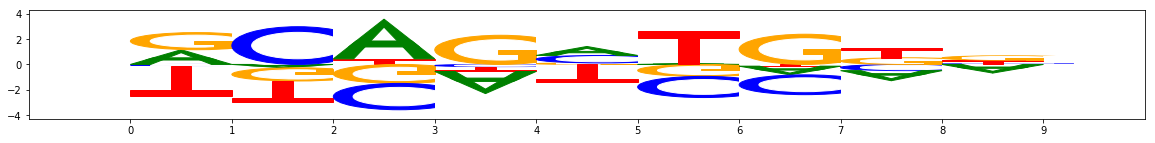

In [11]:
%matplotlib inline
from modisco.visualization import viz_sequence
viz_sequence.plot_weights(TAL1_hocomoco_pwm-np.mean(TAL1_hocomoco_pwm,axis=-1)[:,None])

In [12]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def fast_pwm_scan(array, pwm):
    strided_arr = rolling_window(array.transpose((0,2,1)), window=len(pwm)).transpose((0,2,3,1))
    pwm_scores = np.sum(strided_arr*pwm[None,None,:,:],axis=(2,3))
    return pwm_scores

def sliding_importance_sum(array, window):
    per_position_imp = np.sum(array, axis=-1)
    return np.sum(rolling_window(a=per_position_imp, window=window),axis=-1)

tal_pwm_scores = fast_pwm_scan(array=sequence_onehot, pwm=TAL1_hocomoco_pwm)
importance_in_windows = sliding_importance_sum(array=imp_scores, window=len(TAL1_hocomoco_pwm))

In [15]:
from collections import OrderedDict
important_windows = OrderedDict()
sorted_tal_hits = OrderedDict()
for thresh in [1,0]:
    important_windows[thresh] = np.nonzero(importance_in_windows > thresh)
    #first sort by TAL hit score, then by importance
    sorted_tal_hits[thresh] = sorted(sorted(zip(importance_in_windows[
                                          important_windows[thresh][0], important_windows[thresh][1]], 
                                         tal_pwm_scores[important_windows[thresh][0], important_windows[thresh][1]],
                                         important_windows[thresh][0],
                                         important_windows[thresh][1]),
                                        key=lambda x: -x[0]),
                                         key=lambda x: -x[1])

Plotting top TAL hits where total importance at the motif exceeds 0
107085 204


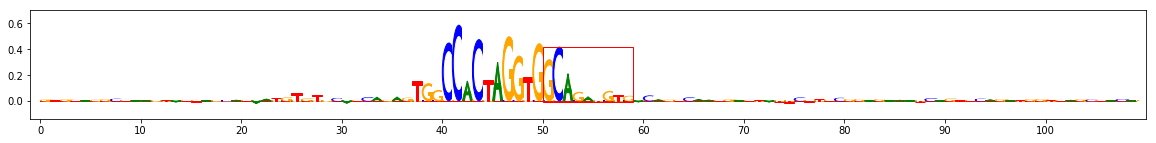

116677 218


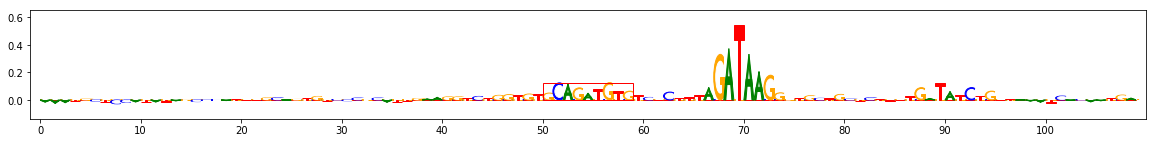

31336 190


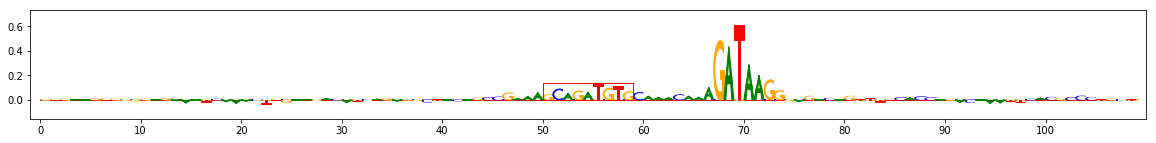

189846 218


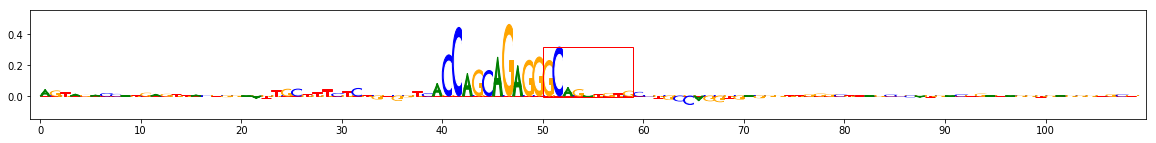

127754 213


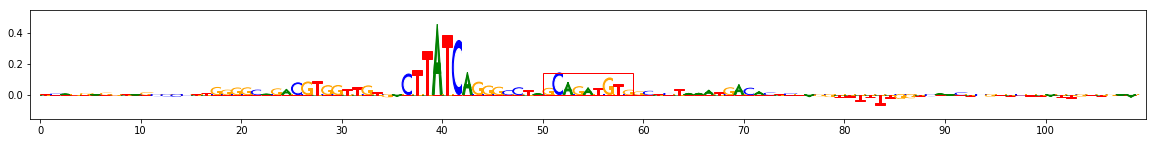

22231 226


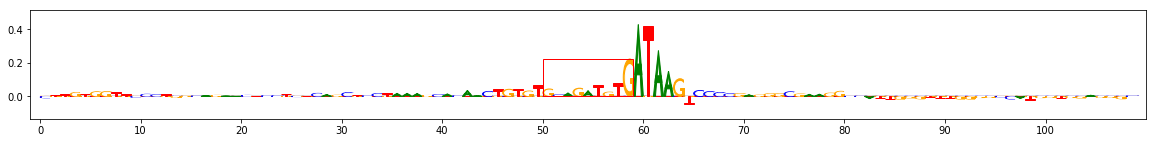

175709 163


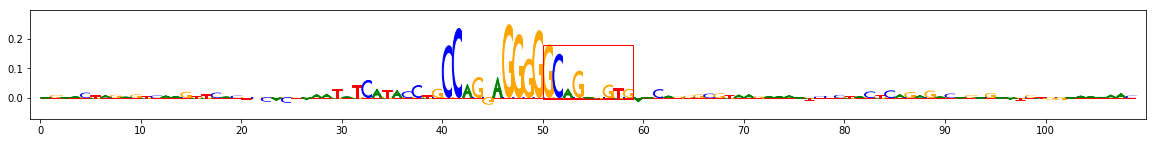

76201 170


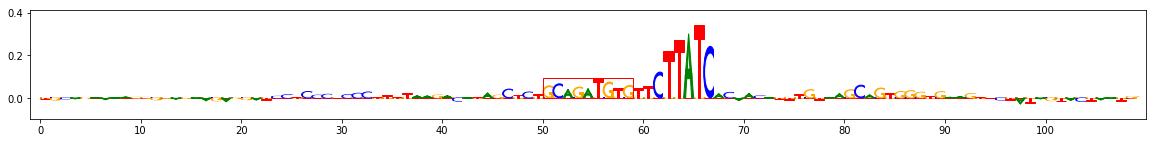

207176 211


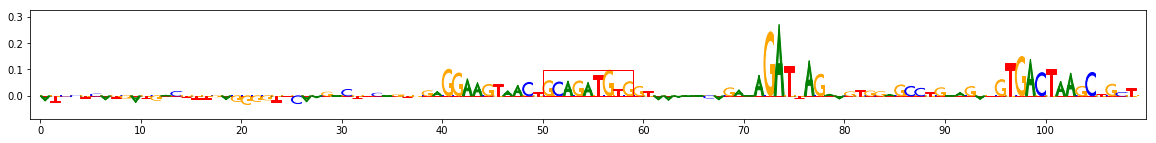

5978 155


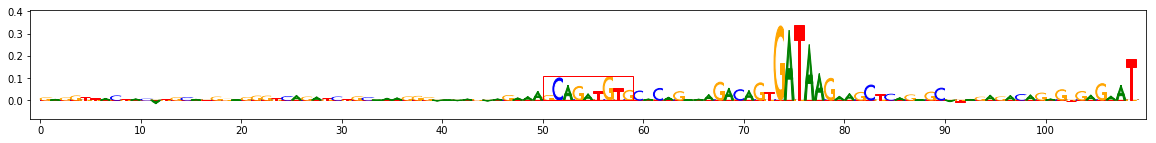

144304 283


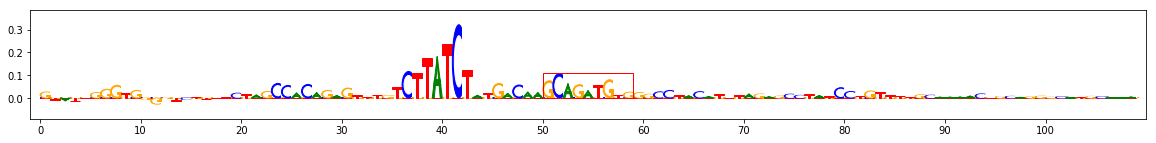

184743 173


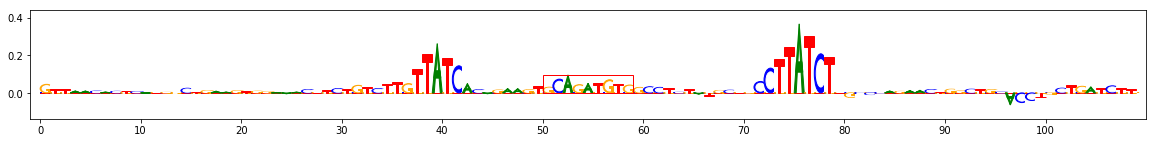

5144 183


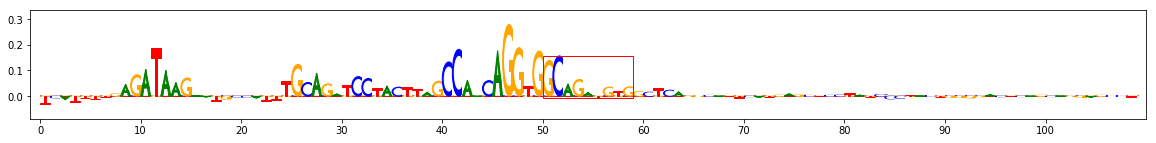

49800 248


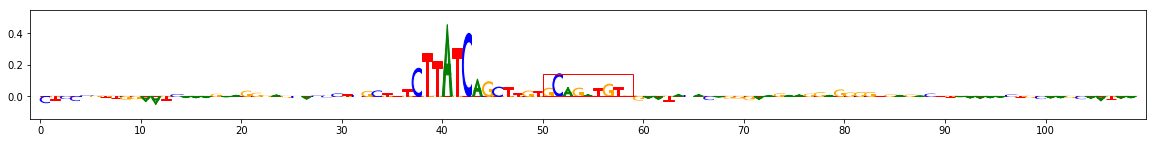

115031 187


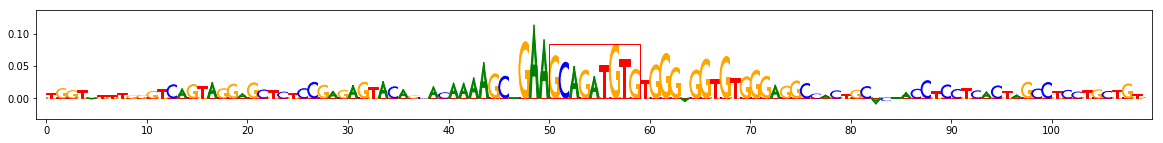

88459 145


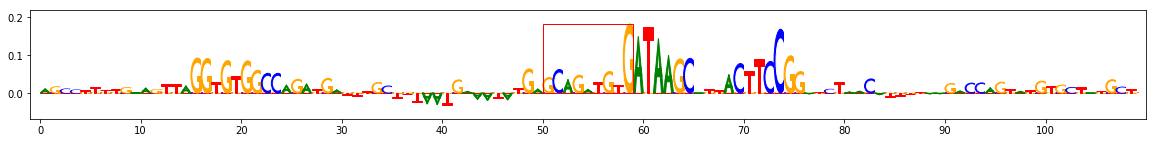

46082 205


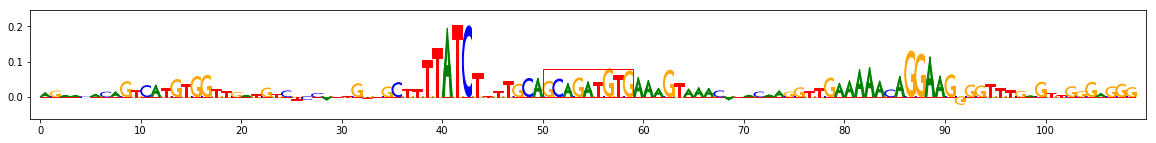

105928 234


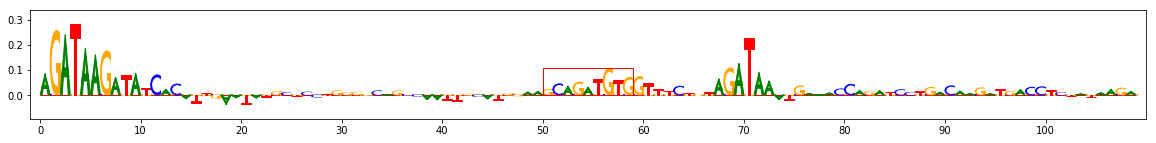

84937 156


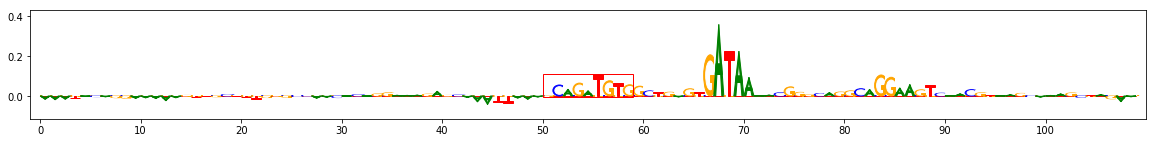

105478 171


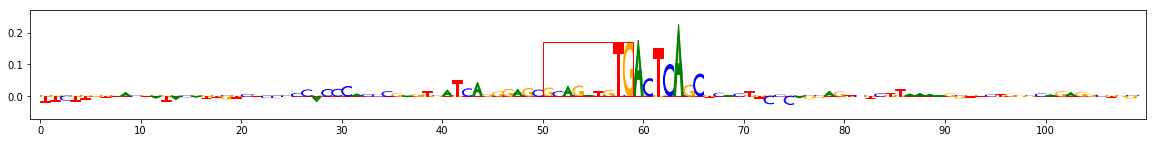

70841 186


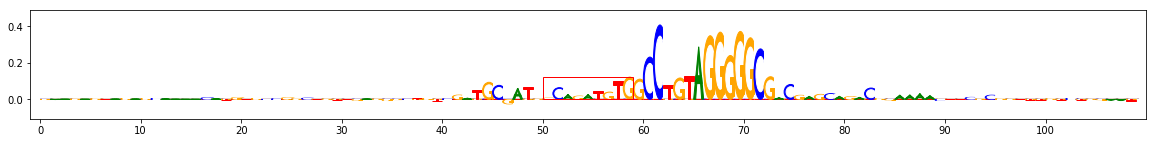

178215 145


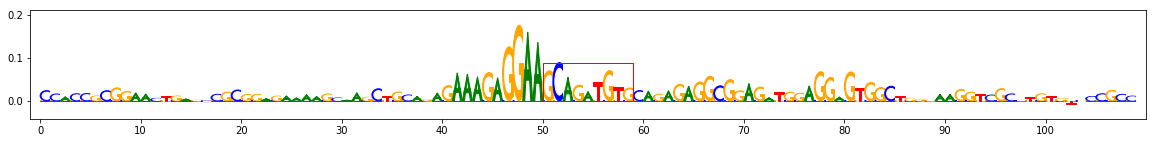

113299 190


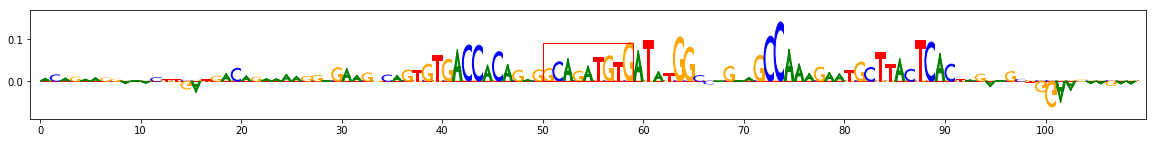

192916 199


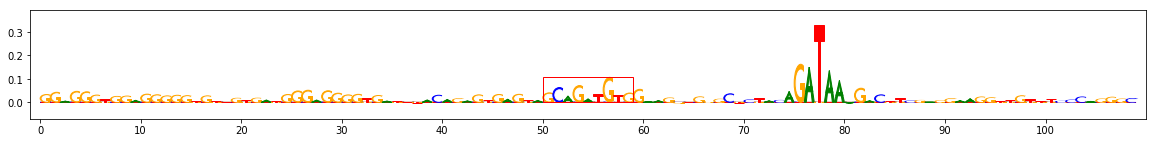

106514 235


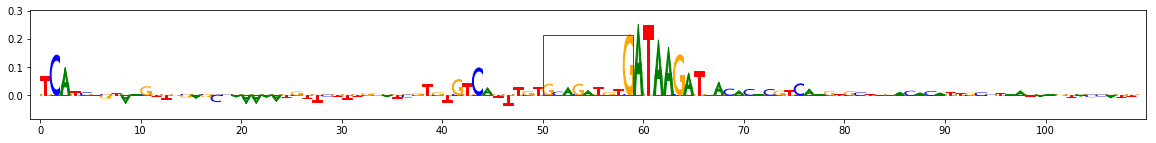

192709 152


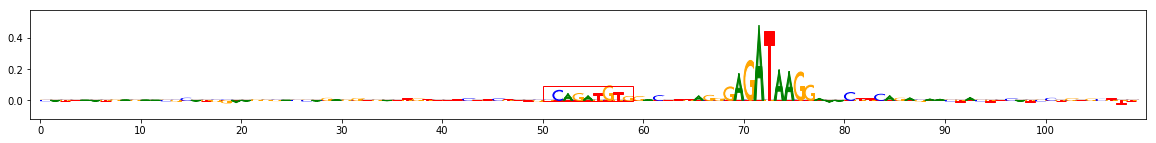

206601 268


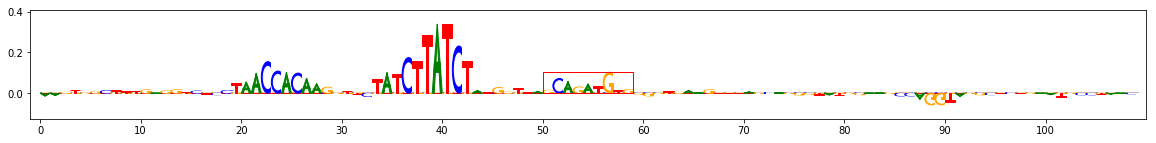

149804 204


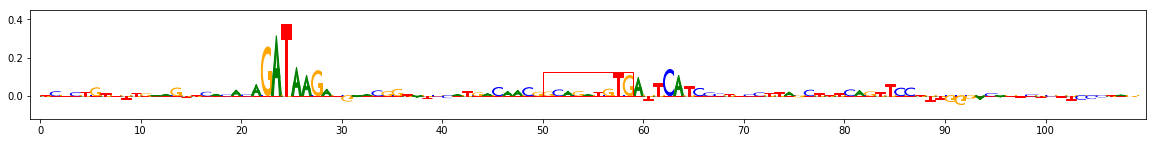

45209 198


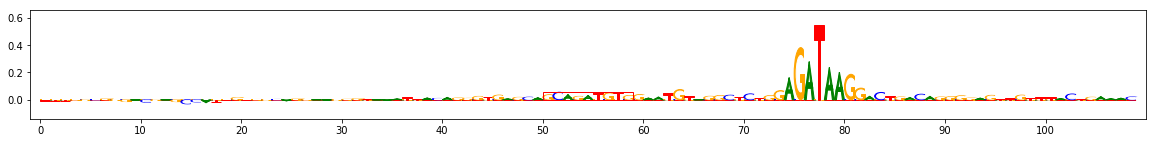

170472 227


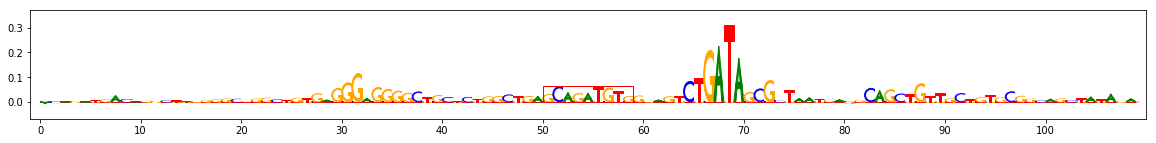

In [20]:
flank=50
for thresh in [0]:
    print("Plotting top TAL hits where total importance at the motif exceeds",thresh)
    for idx in range(30):
        print(sorted_tal_hits[thresh][idx][2], sorted_tal_hits[thresh][idx][3])
        viz_sequence.plot_weights(imp_scores[sorted_tal_hits[thresh][idx][2],
                                             sorted_tal_hits[thresh][idx][3]-flank:
                                             sorted_tal_hits[thresh][idx][3]+(flank+len(TAL1_hocomoco_pwm))],
                                  subticks_frequency=10,
                                  highlight={'red':[(flank,flank+len(TAL1_hocomoco_pwm))]})
        #viz_sequence.plot_weights(sequence_onehot[sorted_tal_hits[thresh][idx][2],
        #                                     sorted_tal_hits[thresh][idx][3]-flank:
        #                                     sorted_tal_hits[thresh][idx][3]+(flank+len(TAL1_hocomoco_pwm))],
        #                          subticks_frequency=10,
        #                          highlight={'red':[(flank,flank+len(TAL1_hocomoco_pwm))]})